# Analyze Heavy Correlations

This jupyter notebook analyzes one-time correlations calculated from the heavy trajectories of ReadRun.py

Observables are:
- Self-intermediate scattering function
- Mean-square displacement
- Force-force correlations
- Velocity-velocity correlations
- Force-velocity correlations

In [1]:
#!/usr/local/miniconda3/bin/python

import sys
import os
sys.executable
from __future__ import print_function
import numpy as np
import hoomd
from hoomd import md
import gsd.pygsd
import gsd.hoomd
import lib.module_measurements as med
from gsd import fl
from freud.box import Box
from matplotlib import pyplot as plt
from scipy.stats import sem


## Import data

In [2]:
maindir='../../OUTPUT/T2.0/N65/S9/heavyTraj/'

In [3]:
#Read L and dt
name=maindir+'/L.txt'
f=open(name,'rt')
L=np.float64(f.readline())
dt=np.float64(f.readline())
f.close()

In [11]:
#Read list of times
timesName=maindir+'/times.txt'
timelist=np.loadtxt(timesName)
ntimes=len(timelist)
print('There are ',ntimes,' configurations in total')

#Read accelerations
pos = []
vel = []
acc = []
fpos=open(maindir+'/pos.npy','rb')
fvel=open(maindir+'/vel.npy','rb')
facc=open(maindir+'/acc.npy','rb')
for i in range(ntimes):
    pos.append(np.load(fpos))
    vel.append(np.load(fvel))
    acc.append(np.load(facc))
fpos.close()
fvel.close()
facc.close()

#Relevant quantities
Natoms=len(pos[0])
initialPositions=pos[0]
pos=np.array(pos)
vel=np.array(vel)
acc=np.array(acc)

#Sort observables
twlist=np.unique(timelist[:,0])
ntw=len(twlist)
# print("twlist: ",twlist)
print("ntw: ",ntw)

tlist=[]
poslist=[]
vellist=[]
acclist=[]
nt=0
for itw in range(ntw):
    tw=twlist[itw]
    thistw=np.where(timelist[:,0]==tw)
    first=thistw[0][0]
    last=thistw[0][-1]+1
    if last-first>nt: 
        nt=last-first
        tlist=np.array(timelist[first:last][:,1]-timelist[first][1])
    poslist.append(pos[first:last])
    vellist.append(vel[first:last])
    acclist.append(acc[first:last])

#Remove incomplete entries
for itw in np.arange(ntw-1,-1,-1):
    if len(poslist[itw]) != nt:
        assert(len(vellist[itw]) == len(poslist[itw]))
        assert(len(acclist[itw]) == len(poslist[itw]))
        del poslist[itw]
        del vellist[itw]
        del acclist[itw]
        twlist=np.delete(twlist,itw)
        
#poslist, vellist and acclist have the shape: [itw, it, particle, component]
ntw=len(twlist)
print("new ntw: ",ntw)
print('tlist: ',tlist)
print('nt: ',nt)
print(np.shape(poslist))
print(np.shape(vellist))
print(np.shape(acclist))
del pos,vel,acc,timelist


There are  435  configurations in total
ntw:  5
new ntw:  5
tlist:  [0.0000e+00 1.0000e+00 2.0000e+00 3.0000e+00 4.0000e+00 5.0000e+00
 6.0000e+00 7.0000e+00 8.0000e+00 9.0000e+00 1.0000e+01 1.1000e+01
 1.2000e+01 1.3000e+01 1.5000e+01 1.6000e+01 1.8000e+01 2.0000e+01
 2.2000e+01 2.5000e+01 2.7000e+01 3.0000e+01 3.3000e+01 3.7000e+01
 4.0000e+01 4.5000e+01 4.9000e+01 5.5000e+01 6.0000e+01 6.7000e+01
 7.4000e+01 8.2000e+01 9.0000e+01 1.0000e+02 1.1000e+02 1.2200e+02
 1.3500e+02 1.4900e+02 1.6400e+02 1.8200e+02 2.0100e+02 2.2200e+02
 2.4500e+02 2.7100e+02 2.9900e+02 3.3100e+02 3.6600e+02 4.0400e+02
 4.4700e+02 4.9400e+02 5.4600e+02 6.0300e+02 6.6700e+02 7.3700e+02
 8.1400e+02 9.0000e+02 9.9500e+02 1.0990e+03 1.2150e+03 1.3430e+03
 1.4840e+03 1.6400e+03 1.8130e+03 2.0030e+03 2.2140e+03 2.4470e+03
 2.7050e+03 2.9890e+03 3.3040e+03 3.6510e+03 4.0350e+03 4.4600e+03
 4.9290e+03 5.4480e+03 6.0210e+03 6.6550e+03 7.3550e+03 8.1280e+03
 8.9840e+03 9.9290e+03 1.0973e+04 1.2128e+04 1.3404e+04 1.481

## Calculate observables

In [12]:
#Wave vector for the self-intermediate scattring function
# k =[2 pi/L](n1,n2,n3) and permutations
n1=1; n2=3; n3=4

msd = np.zeros((ntw, nt), dtype=np.float64)
Fk  = np.zeros((ntw, nt), dtype=np.float64)
CPP = np.zeros((ntw, nt), dtype=np.float64)
CFP = np.zeros((ntw, nt), dtype=np.float64)
CFF = np.zeros((ntw, nt), dtype=np.float64)
for itw in range(ntw):
    initialPositions[:]=poslist[itw][0][:]
    for iframe in range(0, nt):
        msd[itw][iframe]=med.PeriodicSquareDistance(poslist[itw][iframe], initialPositions, L)/Natoms
        all_displacements=med.PeriodicDisplacement(poslist[itw][iframe], initialPositions, L)
        Fk[itw][iframe]=med.ComputeFkt(n1, n2, n3, L, all_displacements)

    CPP[itw]=np.array([np.mean([np.inner(vellist[itw][0][atom],vellist[itw][time][atom]) for atom in range(Natoms)]) for time in range(nt)])/3.
    CFP[itw]=np.array([np.mean([np.inner(acclist[itw][0][atom],vellist[itw][time][atom]) for atom in range(Natoms)]) for time in range(nt)])/3.
    CFF[itw]=np.array([np.mean([np.inner(acclist[itw][0][atom],acclist[itw][time][atom]) for atom in range(Natoms)]) for time in range(nt)])/3.

obs={
    'msd':{'mean': np.mean(msd,axis=0), 'err': sem(msd,axis=0)},
    'Fk':{'mean': np.mean(Fk,axis=0), 'err': sem(Fk,axis=0)},
    'CPP':{'mean': np.mean(CPP,axis=0), 'err': sem(CPP,axis=0)},
    'CFP':{'mean': np.mean(CFP,axis=0), 'err': sem(CFP,axis=0)},
    'CFF':{'mean': np.mean(CFF,axis=0), 'err': sem(CFF,axis=0)},
}


## Plot

### Mean Square Displacement

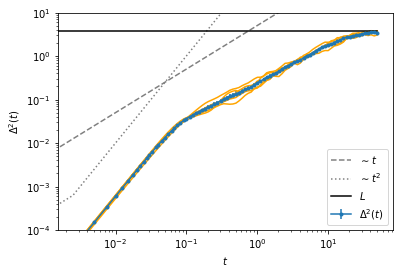

In [13]:
x=tlist*dt

fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.set_xscale('log', nonposx='clip')
ax.set_yscale('log', nonposy='clip')
plt.ylim((1e-4,10))
plt.errorbar(x,obs['msd']['mean'],yerr=obs['msd']['err'],label='$\Delta^2(t)$',marker='.')
for itw in range(ntw):
    plt.plot(x,msd[itw], color='orange')
plt.plot(x,5*x,label='$\sim t$',linestyle='--',color='gray')
plt.plot(x,100*np.square(x),label='$\sim t^2$',linestyle=':',color='gray')
plt.plot(x,L*np.ones(len(x)),label='$L$',color='black')
plt.ylabel('$\Delta^2(t)$')
plt.xlabel('$t$')
plt.legend()
plt.show()



### Self-intermediate scattering function

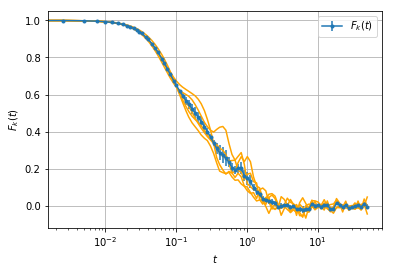

In [14]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.set_xscale('log', nonposx='clip')
plt.errorbar(x,obs['Fk']['mean'],yerr=obs['Fk']['err'],label='$F_k(t)$',marker='.')
for itw in range(ntw):
    plt.plot(x,Fk[itw], color='orange')
plt.legend()
plt.ylabel('$F_k(t)$')
plt.xlabel('$t$')
plt.grid()
plt.show()

### Momentum-momentum correlation function

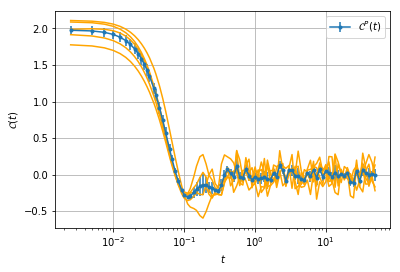

In [15]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.set_xscale('log', nonposx='mask')
plt.errorbar(x,obs['CPP']['mean'],yerr=obs['CPP']['err'],label='$\mathcal{C}^{P}(t)$',marker='.')
for itw in range(ntw):
    plt.plot(x,CPP[itw], color='orange')
plt.legend()
plt.ylabel('$\mathcal{C}(t)$')
plt.xlabel('$t$')
plt.grid()
plt.show()

### Force-momentum correlation function

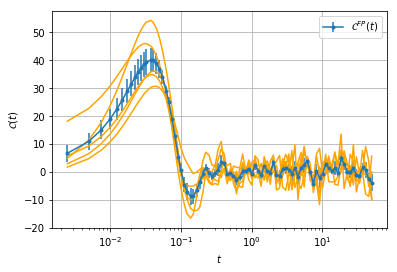

In [16]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.set_xscale('log', nonposx='mask')
plt.errorbar(x,obs['CFP']['mean'],yerr=obs['CFP']['err'],label='$\mathcal{C}^{FP}(t)$',marker='.')
for itw in range(ntw):
    plt.plot(x,CFP[itw], color='orange')
plt.legend()
plt.ylabel('$\mathcal{C}(t)$')
plt.xlabel('$t$')
plt.grid()
plt.show()

### Force-force correlation function

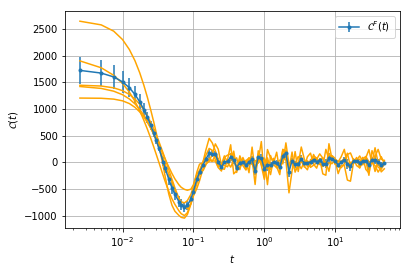

In [17]:
#plt.semilogx(x,obs['CFF']['mean'],label='$\mathcal{C}^{F}(t)$',marker='.')
fig=plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale("log", nonposx='mask')
plt.errorbar(x,obs['CFF']['mean'], yerr=obs['CFF']['err'],label='$\mathcal{C}^{F}(t)$',marker='.')
for itw in range(ntw):
    plt.plot(x,CFF[itw], color='orange')
plt.legend()
plt.ylabel('$\mathcal{C}(t)$')
plt.xlabel('$t$')
plt.grid()
plt.show()
